In [1]:
import torch
import torch.nn as nn
from siamese_model import *
from siamese_data_preprocessing import *
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [4]:
siamese_dataset = SiameseNetworkDataset(pairs_dir="siamese_pairs.csv", transform=T.ToTensor())

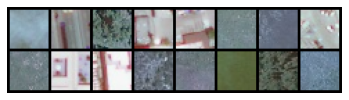

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [5]:
vis_dataloader = DataLoader(siamese_dataset, batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [6]:
np.array(example_batch[0][0].size())  # shape of single image

array([ 3, 28, 28])

In [7]:
TRAIN_RATIO = 0.75
VAL_RATIO = 1 - TRAIN_RATIO
EPOCHS = 3
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
FULL_BATCH_SIZE = 32

In [8]:
print("------------ Creating Dataset ------------")

train_size = int(TRAIN_RATIO * len(siamese_dataset))
val_size = len(siamese_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    siamese_dataset, [train_size, val_size]
)

print("------------ Dataset Created ------------")
print("------------ Creating DataLoader ------------")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=TEST_BATCH_SIZE
)

full_loader = torch.utils.data.DataLoader(
    siamese_dataset, batch_size=FULL_BATCH_SIZE
)
print("------------ Dataloader Cretead ------------")

------------ Creating Dataset ------------
------------ Dataset Created ------------
------------ Creating DataLoader ------------
------------ Dataloader Cretead ------------


In [9]:
net = SiameseNetwork([28, 28])
cos = nn.CosineSimilarity()
criterion = nn.BCELoss()

net.to(device)
cos.to(device)
criterion.to(device)

BCELoss()

In [10]:
optimizer = optim.Adam(net.parameters(), lr = 0.0005)

In [11]:
len(train_loader)

46875

In [5]:
def train_step(net, cos, criterion, optimizer, train_loader, device, log_interval=5000):
    net.train()
    total_loss = 0
    
    for i, data in enumerate(train_loader):
        img0, img1 , label = data
        img0, img1 , label = img0.to(device), img1.to(device), label.to(device)
        
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        pred = cos(output1, output2)
        
        pred = torch.clamp(pred, min=0.0, max=1.0)  # required for BCE; values beyond don't matter due to the log component anyway
        pred = pred.unsqueeze(1)  # because label is of size (batch_size, 1)
        pred = pred.float()
        
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if i % log_interval == 0 and i != 0:
            print("{}/{} batches done".format(i, len(train_loader)))
    
    return total_loss/len(train_loader)

In [6]:
def val_step(net, cos, criterion, val_loader, device):
    net.eval()
    total_loss = 0
    
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            img0, img1 , label = data
            img0, img1 , label = img0.to(device), img1.to(device), label.to(device)
            
            output1, output2 = net(img0, img1)
            pred = cos(output1, output2)
            
            pred = torch.clamp(pred, min=0.0, max=1.0)  # required for BCE; values beyond don't matter due to the log component anyway
            pred = pred.unsqueeze(1)  # because label is of size (batch_size, 1)
            pred = pred.float()

            loss = criterion(pred, label)

            total_loss += loss.item()
    
    print("Validated over {} batches".format(len(val_loader)))
    return total_loss/len(val_loader)

In [18]:
best_val_loss = None
print("------------ Training started ------------")
epoch_logs = []

try:
    for epoch in tqdm(range(EPOCHS)):
        start = time.time()
        train_loss = train_step(net, cos, criterion, optimizer, train_loader, device)
        train_time = time.time() - start
        print(f"Epoch : {epoch}, Training Loss : {train_loss}")
        start = time.time()
        val_loss = val_step(net, cos, criterion, val_loader, device)
        val_time = time.time() - start
        
        epoch_logs.append([epoch, train_time, val_time, train_loss, val_loss])

        # Save best model based on val loss
        if not best_val_loss or val_loss < best_val_loss:
            print("Validation Loss decreased, saving new best model")
            with open('best_model.pt', 'wb') as f:
                torch.save(net, f)
            best_val_loss = val_loss

        print(f"Epoch : {epoch}, Validation Loss : {val_loss}")
    print("------------ Training complete ------------")
except KeyboardInterrupt:
    print('------------ Exiting from training early ------------')

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

------------ Training started ------------
5000/46875 batches done
10000/46875 batches done
15000/46875 batches done
20000/46875 batches done
25000/46875 batches done
30000/46875 batches done
35000/46875 batches done
40000/46875 batches done
45000/46875 batches done
Epoch : 0, Training Loss : 0.34227005365002156


 33%|██████████████████████████▋                                                     | 1/3 [44:10<1:28:21, 2650.55s/it]

Validated over 15625 batches
Validation Loss decreased, saving new best model
Epoch : 0, Validation Loss : 0.05850815536761284
5000/46875 batches done
10000/46875 batches done
15000/46875 batches done
20000/46875 batches done
25000/46875 batches done
30000/46875 batches done
35000/46875 batches done
40000/46875 batches done
45000/46875 batches done
Epoch : 1, Training Loss : 0.1765245417632063


 67%|█████████████████████████████████████████████████████▎                          | 2/3 [1:38:11<49:57, 2997.94s/it]

Validated over 15625 batches
Validation Loss decreased, saving new best model
Epoch : 1, Validation Loss : 0.011740780207796954
5000/46875 batches done
10000/46875 batches done
15000/46875 batches done
20000/46875 batches done
25000/46875 batches done
30000/46875 batches done
35000/46875 batches done
40000/46875 batches done
45000/46875 batches done
Epoch : 2, Training Loss : 0.11127807555649616


100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [2:24:11<00:00, 2883.86s/it]

Validated over 15625 batches
Validation Loss decreased, saving new best model
Epoch : 2, Validation Loss : 0.00115566977856867
------------ Training complete ------------


# Testing more parameters with a mini train set
Edit the below code as necessary to test parameters on a reduced training dataset (10% of full data)

In [10]:
MINI_RATIO = 0.1
MINI_BATCH_SIZE = 32
EMB_SIZE=100

In [11]:
mini_train_size = int(MINI_RATIO * len(siamese_dataset))
mini_train_dataset, mini_val_dataset, _ = torch.utils.data.random_split(
    siamese_dataset, [mini_train_size, mini_train_size, (len(siamese_dataset) - 2*mini_train_size)]
)

mini_train_loader = torch.utils.data.DataLoader(
    mini_train_dataset, batch_size=MINI_BATCH_SIZE, shuffle=True, drop_last=True
)
mini_val_loader = torch.utils.data.DataLoader(
    mini_val_dataset, batch_size=MINI_BATCH_SIZE
)

param_net = SiameseNetwork([28, 28], EMB_SIZE)
param_cos = nn.CosineSimilarity()
param_criterion = nn.BCELoss()

param_net.to(device)
param_cos.to(device)
param_criterion.to(device)

param_optimizer = optim.Adam(param_net.parameters(), lr = 0.0005)

print(len(mini_train_loader))

6250


In [12]:
print("------------ Training started ------------")

start = time.time()
train_loss = train_step(param_net, param_cos, param_criterion, param_optimizer, mini_train_loader, device, 1000)
train_time = time.time() - start
print(f"Training Loss : {train_loss} | Training Time : {train_time} seconds")
start = time.time()
val_loss = val_step(param_net, param_cos, param_criterion, mini_val_loader, device)
val_time = time.time() - start

print(f"Validation Loss : {val_loss} | Validation Time : {val_time} seconds")
print("------------ Training complete ------------")

------------ Training started ------------
1000/6250 batches done
2000/6250 batches done
3000/6250 batches done
4000/6250 batches done
5000/6250 batches done
6000/6250 batches done
Training Loss : 0.7665260680007935 | Training Time : 265.28799080848694 seconds
Validated over 6250 batches
Validation Loss : 0.24425383743464946 | Validation Time : 236.83341431617737 seconds
------------ Training complete ------------
